#### Alexander Lerma

#### Zhiwei Zhang

#### Anoopa Sundararajan

#### Landi Gu

# 2. Model Calibration and Testing

In [1]:
%matplotlib inline
from model.binomial import EuropeanVanillaModel, HullWhiteEuropeanModel, HullWhiteAmericanModel
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### GS Stock Prices (Nov 30, 2016 - Feb 27, 2017)

We chose these dates because they are between dividend paying dates of *Nov 29,2016* and *Feb 28, 2017*

We'll only need closing price from the stock data and will compute the ratio of the closing price for each day

$$ ratio(p_i) = \frac{p_{i+1}}{p_{i}} $$

In [2]:
stock_prices = pd.read_csv('dataset/gs-stock-prices.csv', index_col=0, parse_dates=True).iloc[::-1]
stock_prices['Ratio'] = [np.nan if i + 1 == len(stock_prices) else stock_prices['Close'][i+1] / price for i, price in enumerate(stock_prices['Close'])]
stock_prices.drop([col for col in stock_prices.columns if col not in ['Close', 'Ratio']], axis=1, inplace=True)
stock_prices[:]

,Close,Ratio
Date,,
2016-11-30,219.289993,1.033472
2016-12-01,226.630005,0.985571
2016-12-02,223.360001,1.023236
2016-12-05,228.550003,1.012382
2016-12-06,231.380005,1.018065
2016-12-07,235.559998,1.025004
2016-12-08,241.449997,1.001657
2016-12-09,241.850006,0.980649
2016-12-12,237.169998,1.005819


##### Method:
Hull-White Model
##### Current Date: 
03-17-2017 
##### USD LIBOR - 12 months: 
1.81317 %
##### GS Option Expiration Date: 
06-16-2017


In [3]:
T = (date(2017,6,16) - date.today()).days / 365
dt = 11 / 365
s0 = 242.14
r = .0181317
n_steps = 8
n_training = len(stock_prices)

In [4]:
gs_calls = pd.read_csv('dataset/gs-calls.csv')
call_results = []
option = 'call'

for k in gs_calls['Strike']:
    american = HullWhiteAmericanModel(k, T, dt, r, n_steps, option, n_training, stock_prices, s0)
    euro = HullWhiteEuropeanModel(k, T, dt, r, n_steps, option, n_training, stock_prices, s0)
    call_results.append((k, american.price(), euro.price()))
    
call_df = pd.DataFrame(call_results, columns=['Strike', 'American', 'European'])
call_df['Actual'] = gs_calls['Last Price']

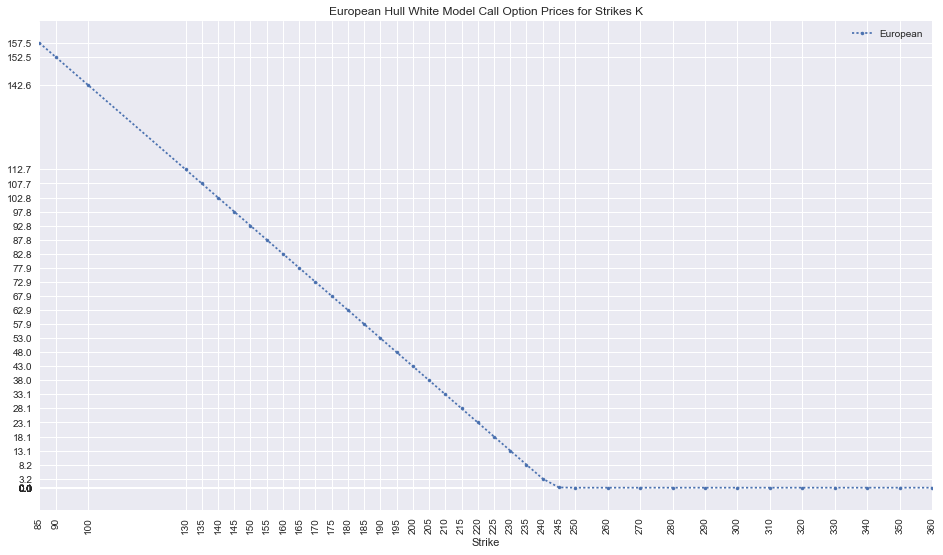

In [5]:
call_df[['Strike','European']].plot(x='Strike', 
                                    y='European',
                                    title='European Hull White Model Call Option Prices for Strikes K',
                                    figsize=(16,9),
                                    xticks=call_df['Strike'],
                                    yticks=call_df['European'],
                                    kind='line',
                                    rot=90,
                                    style=[':'],
                                    marker='.')

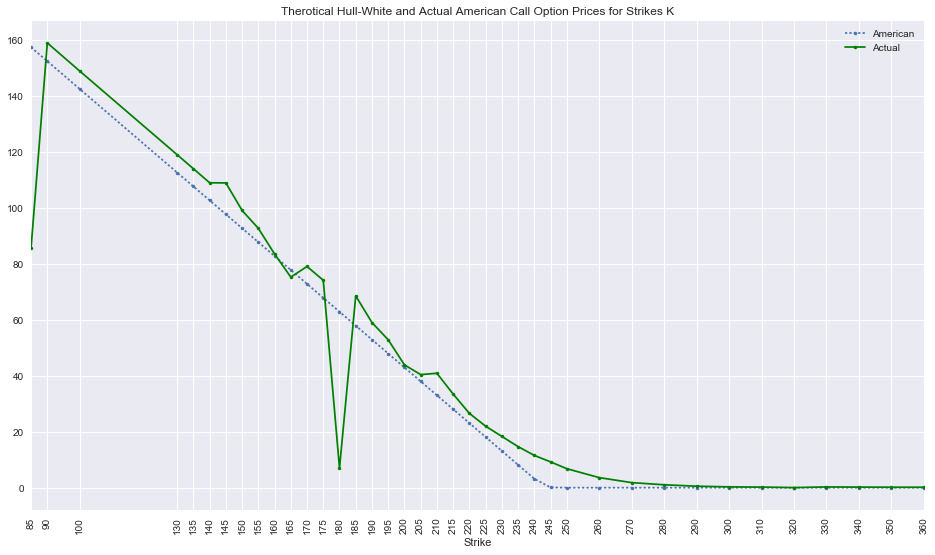

In [6]:
call_df[['Strike','American', 'Actual']].plot(x='Strike', 
                                              title='Therotical Hull-White and Actual American Call Option Prices for Strikes K',
                                              figsize=(16,9),
                                              xticks=call_df['Strike'],
                                              kind='line',
                                              rot=90,
                                              style=[':', '-g'],
                                              marker='.')

In [7]:
gs_puts = pd.read_csv('dataset/gs-puts.csv')
put_results = []
option = 'put'

for k in gs_puts['Strike']:
    american = HullWhiteAmericanModel(k, T, dt, r, n_steps, option, n_training, stock_prices, s0)
    euro = HullWhiteEuropeanModel(k, T, dt, r, n_steps, option, n_training, stock_prices, s0)
    put_results.append((k, american.price(), euro.price()))
    
put_df = pd.DataFrame(put_results, columns=['Strike', 'American', 'European'])
put_df['Actual'] = gs_puts['Last Price']

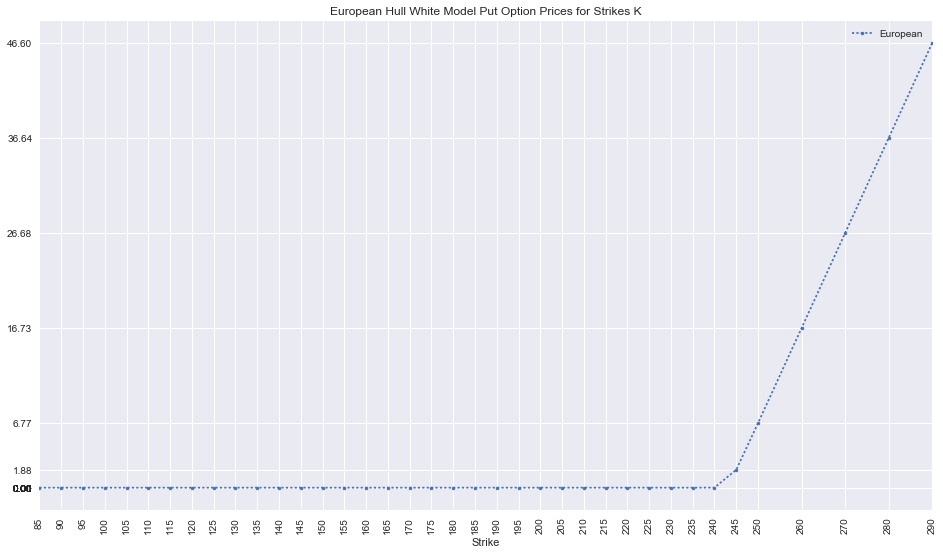

In [8]:
put_df[['Strike','European']].plot(x='Strike', 
                                   y='European',
                                   title='European Hull White Model Put Option Prices for Strikes K',
                                   figsize=(16,9),
                                   xticks=put_df['Strike'],
                                   yticks=put_df['European'],
                                   kind='line',
                                   rot=90,
                                   style=[':'],
                                   marker='.')

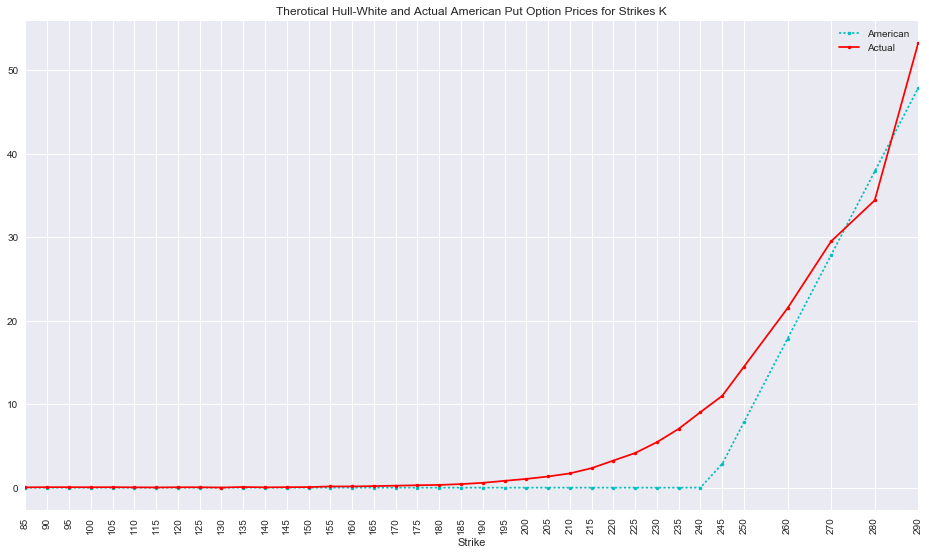

In [9]:
put_df[['Strike','American', 'Actual']].plot(x='Strike', 
                                             title='Therotical Hull-White and Actual American Put Option Prices for Strikes K',
                                             figsize=(16,9),
                                             xticks=put_df['Strike'],
                                             kind='line',
                                             rot=90,
                                             style=[':c', 'r'],
                                             marker='.')